<a href="https://colab.research.google.com/github/llcorrea/gradient_descent/blob/main/GradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation of the method of Gradient Descent**

This code implements a Gradient Descent (GD) from scratch in order to minimize a loss function through a linear regression problem.

However, Gradient Descent can be employed in different ML algorithms and scenarios. 

Basically, the algorithm is used in the ML training step to find, as an optimization process, a set of weights and biases that have low loss, on average, across the entire training dataset.

To demonstrate the usage of the GD and its applicability to a linear regression problem, we are going to explore the dataset of *Marketing and Sales* from Kaggle, which contains information about TV, influencer, radio, and social media ads budget related to sales.

Dataset from Kaggle:
https://www.kaggle.com/harrimansaragih/dummy-advertising-and-sales-data

In [45]:
import sys
import io
import pdb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from google.colab import files
import re

# **Loading CSV files into Colab from a local drive**

In [46]:
try:
  train_data = pd.read_csv('train_sales.csv')
except:
  uploaded = files.upload()
  train_data = pd.read_csv('train_sales.csv')

# **EDA step**

> **Dataset size:** 4572 entries\
> **Number of features:** 5 features\
> **Target feature:** Sales

* Each entry is a digital seller.

* The target feature (Sales) indicates the amount of money in sales a given seller has earned based on the other features.

**Missing values:**

* **Dataset features:**  
  * TV (10)
  * Radio (4)
  * Social Media (6)
  * Sales (6)

In [47]:
print(train_data.shape)
print(train_data.head())

#print(train_data.tail())
#print(train_data.columns)
print(train_data.describe())
print(train_data.info())
print(train_data.isnull().sum())

(4572, 5)
     TV      Radio  Social Media Influencer       Sales
0  16.0   6.566231      2.907983       Mega   54.732757
1  13.0   9.237765      2.409567       Mega   46.677897
2  41.0  15.886446      2.913410       Mega  150.177829
3  83.0  30.020028      6.922304       Mega  298.246340
4  15.0   8.437408      1.405998      Micro   56.594181
                TV        Radio  Social Media        Sales
count  4562.000000  4568.000000   4566.000000  4566.000000
mean     54.066857    18.160356      3.323956   192.466602
std      26.125054     9.676958      2.212670    93.133092
min      10.000000     0.000684      0.000031    31.199409
25%      32.000000    10.525957      1.527849   112.322882
50%      53.000000    17.859513      3.055565   189.231172
75%      77.000000    25.649730      4.807558   272.507922
max     100.000000    48.871161     13.981662   364.079751
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column      

# **Correlation between features**

,TV,Radio,Social Media,Sales
TV,1.000000,0.869460,0.528168,0.999497
Radio,0.869460,1.000000,0.607452,0.869105
Social Media,0.528168,0.607452,1.000000,0.528906
Sales,0.999497,0.869105,0.528906,1.000000


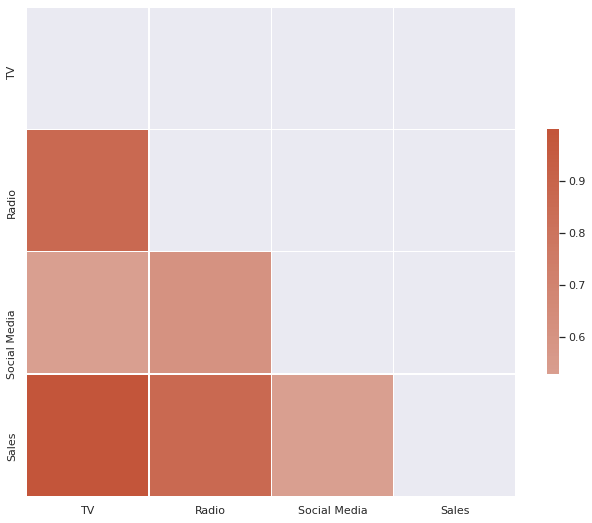

In [48]:
corr=train_data.iloc[:, :].corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **Feature transformation**

In [49]:
train_data = pd.get_dummies(train_data, drop_first = True)
train_data

,TV,Radio,Social Media,Sales,Influencer_Mega,Influencer_Micro,Influencer_Nano
0,16.0,6.566231,2.907983,54.732757,1,0,0
1,13.0,9.237765,2.409567,46.677897,1,0,0
2,41.0,15.886446,2.913410,150.177829,1,0,0
3,83.0,30.020028,6.922304,298.246340,1,0,0
4,15.0,8.437408,1.405998,56.594181,0,1,0
...,...,...,...,...,...,...,...
4567,26.0,4.472360,0.717090,94.685866,0,1,0
4568,71.0,20.610685,6.545573,249.101915,0,0,1
4569,44.0,19.800072,5.096192,163.631457,0,1,0
4570,71.0,17.534640,1.940873,253.610411,0,0,0


# **Prediction of sales**

As a case study to our model, we are going to *predict the sales* based on a single feature: *the Radio feature*, which presents a reasonable correlation with the target feature but not a total one.

Correlation between Sales and Radio of 0.869.

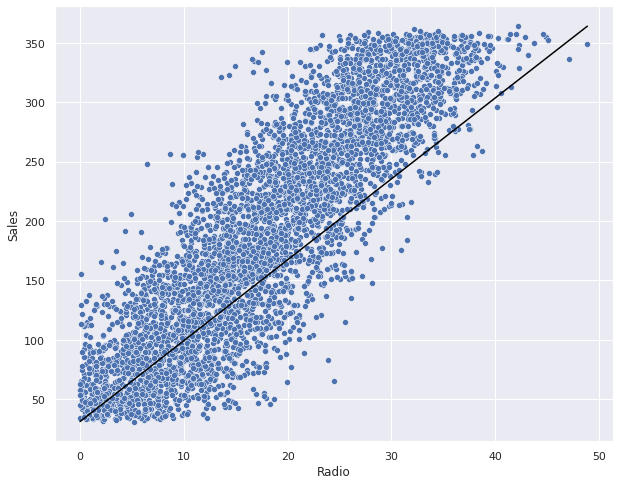

In [50]:
sns.set()
plt.figure(figsize=(10, 8))
sns.scatterplot(y='Sales', x='Radio', data=train_data)
plt.plot([min(train_data['Radio']), max(train_data['Radio'])], [min(train_data['Sales']), max(train_data['Sales'])], color='black')

# **ML steps**

1. Split of the dataset between train and test.

2. Fit the ML model to the train dataset. In this case, we use a linear regression equation.

3. Predict values through the test dataset.

4. Compute loss and accuracy metrics. The Mean Squared Error (MSE) was adopted.

5. If stop criterion is not satisfied, update parameter values based on the loss function and return to the step 2. The update step of the regression parameters is done through the Gradient Descent algorithm.

* Stop criterion: Iterate till overall loss stops changing or at least changes extremely slowly (convergence of the model).

**Treat Missing Data**

Drop the entries with missing data.

In [51]:
train_data=train_data.dropna(axis=0)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4546 entries, 0 to 4571
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TV                4546 non-null   float64
 1   Radio             4546 non-null   float64
 2   Social Media      4546 non-null   float64
 3   Sales             4546 non-null   float64
 4   Influencer_Mega   4546 non-null   uint8  
 5   Influencer_Micro  4546 non-null   uint8  
 6   Influencer_Nano   4546 non-null   uint8  
dtypes: float64(4), uint8(3)
memory usage: 190.9 KB


In [52]:
X = train_data['Radio']
y = train_data['Sales']
display(X.head())
display(y.head())

0     6.566231
1     9.237765
2    15.886446
3    30.020028
4     8.437408
Name: Radio, dtype: float64

0     54.732757
1     46.677897
2    150.177829
3    298.246340
4     56.594181
Name: Sales, dtype: float64

**Data split between train and validation datasets**

In [53]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=376) #test_size=0.3, 0.2
print(train_X.head())
print(train_y.head())

1650     2.181142
4435    11.533551
3384    16.876230
516      9.100429
172     23.434787
Name: Radio, dtype: float64
1650     56.189924
4435    148.130044
3384    108.852312
516     147.593573
172     288.020745
Name: Sales, dtype: float64


# **Implementation of the Linear Regression and Gradient Descent**

Linear regression is a statistical algorithm used to model the relationship between a dependent variable (target) with a set of independent variables (features).

Simple linear regression is used to infer the behavior of a target by using a single feature. It is assumed that the two variables are linearly related. 

**The algorithm implements a linear function to predict the target $(y')$ as a function of the feature $(x)$.**

**Based on our dataset previously described, the independent variable $x$ is the feature *Radio* and the target $y$ is the *Sales*.**



### **Linear regression equation:**

The model tries to find a regression line that better represent the relationship between our variables (independent and dependent ones), so that it's possible to predict the target for any new data.  

This line is modeled by the linear regression equation:

> $y' = mx + b$
>
> Where $b$ means the intercept parameter, which represents the value of $y'$ when $x$ is equal to 0.
>
> The parameter $m$ is the slope of the line (a.k.a. weight of variable $x$ in ML algorithms).
>
> Based on the linear regression equation parameters, we can say that the value of $y'$ (dependent variable of $x$) will be increased in $m$ times at each amount of increasement of the variable $x$. Considering that the initial value of $y'$ when $x=0$ is $b$.

To fit our model to the data, the parameters (regression coefficients) of the linear equation ($b$ and $m$) must be adjusted or estimated. 

To do so, the predicted results from the regression equation are evaluated with a loss function. 

In an iterative cycle, the parameters of the model are modified and re-evaluated in order to reduce the error, i.e., minimize the loss function towards the minimum of the function. 

This update or optimization of parameters can be done in an efficient way through the Gradient Descent algorithm.

After the optimization of the parameters, we can use the model to predict target values based on new values of the independent variable.


### **Gradient Descent algorithm:**

The GD algorithm is an optimizer used to minimize the loss function. It takes parameters and tunes them till the local minimum is reached.

* Requirements of the GD:
  1. Definition of the minimization function. In our case, we use the MSE as loss function.

  2. Definition of parameters to be minimized. The parameters of the regression function are the $m$ and $b$.

  3. Calculation of the partial derivatives of MSE with respect to these parameters. The derivative of each parameter is used to tune it, giving the direction and magnitude to minimize the function.

* Steps of the GD:
  1. Assign starting values for the parameters (*m* and *b*).

  2. Computation of the gradient of the loss curve at the starting points.

  3. Iterative update of parameters via the partial derived functions (gradient) in order to minimize the MSE. Use of the learning rate parameter which defines the step size of the parameter movement at each iteration.

* The gradient in convex landscapes is equal to the derivative (slope) of the curve. When there are multiple parameters, the gradient is a vector of partial derivatives with respect to the parameters.

### **Loss equation:**

The loss related to the fit of the model is the error (difference) between the observed value (y) and the predicted one (y'). 

One of the most common metrics used in ML to score the error is the Mean Squared Error (MSE).

>**Mean squared error:**
>
>$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i - y'_i)^2$
>
>Where $y' = mx + b$



In [54]:
def MSE_function(y, prediction):
  MSE=sum((y - prediction)**2)
  MSE/=len(y)
  return MSE

### **Partial derivatives:**

Partial derivatives describe how much each parameter individually changes the function when it is pertubed.

The derivatives are calculated separately with respect to the parameters (*m* and *b*) of the function to be minimzed. 

Re-writing the MSE equation as function *f(m, b)* with two parameters:

>$f(m, b) = \frac{1}{N}\sum_{i=1}^{N}(y_i - (mx_i + b))^2$

With this, we compute the partial derivative of *f* for each parameter.


#### **Partial first order derivative of *f* with respect to *m* ($\frac{\partial f}{\partial m}$):** 

The partial derivative of *f* w.r.t. *m*, denoted as $\frac{\partial f}{\partial m}$, is the derivative of *f* considered as a function of *m* alone. 

Basically, we derive the parameter *m* of *f*, whereas parameter *b* remains constant, i.e., *b* and anything that is not *m* can be treated as constants (equal to 0). To find $\frac{\partial f}{\partial m}$, we must to hold *b* constant and take the regular derivative of *f* w.r.t. *m*.

Thus, we have the following partial derivative:

> $\frac{\partial f}{\partial m} = \frac{1}{N}\sum_{i=1}^{N} -2x_i (y_i - (mx_i + b))$

#### **Partial first order derivative of *f* with respect to *b* ($\frac{\partial f}{\partial b}$):**

The same rationale explained above is used to derive parameter *b*. Parameter *m* is treated as a constant (equal to 0).
Then, we have the following partial derivative of *f* w.r.t. *b*:

> $\frac{\partial f}{\partial b} = \frac{1}{N}\sum_{i=1}^{N} -2(y_i - (mx_i + b))$


# **Gradient Descent algorithm for parameters *b* and *m***

* Firstly, we start defining random values for $m$ and $b$. 

* Then, the iteration process at each generation compute the gradient descent vector for parameters through the derived functions previously described. The gradient vector of function $f$ ($\nabla f$) is the vector of partial derivatives w.r.t. all of the parameters in $f$. Thus, for each parameter we will have one gradient:

> $\nabla f(m, b) = (\frac{\partial f}{\partial m}, \frac{\partial f}{\partial b})$

* The gradient is a value with direction and magnitude: 
  * $\nabla f$ points to the direction of the greatest increase of the function (maximum local). $\nabla f$ always points to the steepest increase of $f$.

  * $- \nabla f$ points to the oppsosite direction. It points to the greatest decrease of $f$ (minimum local). **With this, the gradient descent $- \nabla f$ is used to minimize the loss function and optimize the parameters of the model.**

* The GD algorithm takes a step in direction of the negative gradient ($- \nabla f$) to reduce the loss of the model.

* The new values for parameters are defined based on the current values added to the negative gradients multiplied by the learning rate, which gives the step size of modification:

> $m = m - \alpha \cdot \frac{\partial f}{\partial m}$
>
> $b = b - \alpha \cdot \frac{\partial f}{\partial b}$




In [55]:
def gradient_descent(X, y, l_rate=0.01, n_gen=20):
  #X=np.array([1, 2, 4, 3, 5])
  #y=np.array([1, 3, 4, 2, 5])

  #l_rate = learning rate
  #n_gen = number of generations to fit the regression

  ##parameters of the linear regression equation
  m=0.0
  b=0.0
  print('initial params', m, b)

  err=[] #acc MSE
  for gen in range(n_gen):
    ##fit the model using the regression equation
    predictions=(m*X + b)

    ##update parameters via Gradient Descent
    f = (predictions - y)
    #derivative of MSE in function of m
    gradient_m = sum(2.0*X*f)/len(X)
    #derivative of MSE in function of b
    gradient_b = sum(2.0*f)/len(X)
    #update parameters
    m = m - (l_rate * gradient_m)
    b = b - (l_rate * gradient_b)
    print('new params', m, b)

    ##MSE
    #mean_squared_error(train_y, predictions) #sklearn implementation 
    err.append(MSE_function(y, predictions))
    print('iter:', gen, 'loss:', err[-1])
  
  #plt.scatter(X, y)
  #plt.scatter(X, predictions)
  #plt.plot([min(X), max(X)], [min(predictions), max(predictions)], color='black')
  #plt.show()
  
  return m, b, err

m, b, err=gradient_descent(train_X, train_y)


initial params 0.0 0.0
new params 85.91108983098184 3.8599572278154644
iter: 0 loss: 45904.395833707094
new params -559.2784135246643 -23.573645142310973
iter: 1 loss: 2452864.9601736753
new params 4285.50901288079 183.97528094528715
iter: 2 loss: 138176750.48205099
new params -32095.00844171052 -1373.0121992635625
iter: 3 loss: 7791375892.77207
new params 241093.3116424177 10320.240754076962
iter: 4 loss: 439339997662.02356
new params -1810331.0145370192 -77485.1471585746
iter: 5 loss: 24773505280921.227
new params 13594213.41537614 581864.1159350132
iter: 6 loss: 1396928507424142.0
new params -102081508.66608764 -4369316.306580981
iter: 7 loss: 7.877000985168949e+16
new params 766550000.1381277 32810062.543779448
iter: 8 loss: 4.4416836073356805e+18
new params -5756173044.715219 -246377127.25954318
iter: 9 loss: 2.5045767170551857e+20
new params 43224223692.16756 1850093815.3404539
iter: 10 loss: 1.4122808119999597e+22
new params -324579107525.29614 -13892714487.301165
iter: 11 loss:

### **Linear Regresion method from SkLearn**

In [56]:
new_X, new_y = train_X.values.reshape(-1, 1), train_y.values.reshape(-1, 1)
reg = LinearRegression().fit(new_X, new_y)
reg.score(new_X, new_y)

0.7605043516452846